<a href="https://colab.research.google.com/github/ekrako/big_data_final/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Install Packages

In [2]:
import sys
import subprocess
import pkg_resources
required = {'utm','kaggle','findspark','geopandas'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
 
if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import json
import geopy.distance
import utm
import os
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score
import findspark


# Get the data

In [3]:
kaggle_json_location='/content/drive/My Drive/Colab Notebooks/Datasets/idc/Big Data/'
 
if 'google.colab' in str(get_ipython()):
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null
  if not os.path.exists('./spark-3.1.2-bin-hadoop3.2.tgz'):
    !wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
    !tar xf spark-3.1.2-bin-hadoop3.2.tgz
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
  findspark.init()
  from pyspark.sql import SparkSession
  from google.colab import drive
    # drive.mount('/content/drive')
 
  if not os.path.exists('~/.kaggle/'):
    !mkdir ~/.kaggle/
  if not os.path.exists('~/.kaggle/kaggle.json'):
    # os.popen(f"cp '{kaggle_json_location}kaggle.json' ~/.kaggle/")
    !cp '/content/drive/My Drive/Colab Notebooks/Datasets/idc/Big Data/kaggle.json' ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json 
if not os.path.exists('./idc_train.csv'):
  !kaggle competitions download -c 'idc-big-data-platforms-2021-ml-competition' 
  !unzip idc_train.csv.zip
 
spark = SparkSession.builder.master("local[*]").getOrCreate()


mkdir: cannot create directory ‘/root/.kaggle/’: File exists


# load train data

In [4]:

df = spark.read.format("csv") \
      .option("header", True) \
      .option("inferSchema", True) \
      .load("idc_train.csv")
df.cache() 
df.printSchema()

root
 |-- key: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



#load test data

In [5]:
test_df = spark.read.format("csv") \
      .option("header", True) \
      .option("inferSchema", True) \
      .load("idc_test.csv")
 
test_df.printSchema()

root
 |-- key: integer (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



# remove rows with wrong data

In [47]:
from pyspark.ml import  Transformer
from pyspark.sql import DataFrame

class FilterTransformer(Transformer):
    """
    A custom Transformer which converts String datetime to datetime
    """

    def __init__(self, max_lat:float,min_lat:float,
                  max_lon:float,min_lon:float,
                  max_fare_amount:float,min_fare_amount:float,
                  max_passenger_count:int,min_passenger_count:int,
                  na_drop:bool=True):
        super(FilterTransformer, self).__init__()
        self.max_lat = max_lat
        self.min_lat = min_lat
        self.max_lon = max_lon
        self.min_lon = min_lon
        self.max_fare_amount = max_fare_amount
        self.min_fare_amount = min_fare_amount
        self.max_passenger_count = max_passenger_count
        self.min_passenger_count = min_passenger_count
        self.na_drop = na_drop

    def _transform(self, df: DataFrame) -> DataFrame:
      if self.na_drop:
        df=df.na.drop()
        df=df.filter(df.pickup_latitude>self.min_lat)
        df=df.filter(df.dropoff_latitude>self.min_lat)
        df=df.filter(df.pickup_latitude<self.max_lat)
        df=df.filter(df.dropoff_latitude<self.max_lat)
        df=df.filter(df.pickup_longitude>self.min_lon)
        df=df.filter(df.dropoff_longitude>self.min_lon)
        df=df.filter(df.pickup_longitude<self.max_lon)
        df=df.filter(df.dropoff_longitude<self.max_lon)
        df=df.filter(df.passenger_count>self.min_passenger_count)
        df=df.filter(df.passenger_count<self.max_passenger_count)
        if 'fare_amount' in df.columns:
          df=df.filter(df.fare_amount>self.min_fare_amount)
          df=df.filter(df.fare_amount<self.max_fare_amount)
      else:
        df=df.withColumn('pickup_latitude',when(df.pickup_latitude>self.min_lat,self.min_lat).otherwise(df.pickup_latitude))
        df=df.withColumn('dropoff_latitude',when(df.dropoff_latitude>self.min_lat,self.min_lat).otherwise(df.dropoff_latitude))
        df=df.withColumn('pickup_latitude',when(df.pickup_latitude<self.max_lat,self.max_lat).otherwise(df.pickup_latitude))
        df=df.withColumn('dropoff_latitude',when(df.dropoff_latitude<self.max_lat,self.max_lat).otherwise(df.dropoff_latitude))
        df=df.withColumn('pickup_longitude',when(df.pickup_longitude>self.min_lon,self.min_lon).otherwise(df.pickup_longitude))
        df=df.withColumn('dropoff_longitude',when(df.dropoff_longitude>self.min_lon,self.min_lon).otherwise(df.dropoff_longitude))
        df=df.withColumn('pickup_longitude',when(df.pickup_longitude<self.max_lon,self.max_lon).otherwise(df.pickup_longitude))
        df=df.withColumn('dropoff_longitude',when(df.dropoff_longitude<self.max_lon,self.max_lon).otherwise(df.dropoff_longitude))
        df=df.withColumn('passenger_count',when(df.passenger_count>self.min_passenger_count,self.min_passenger_count).otherwise(df.passenger_count))
        df=df.withColumn('passenger_count',when(df.passenger_count<self.max_passenger_count,self.max_passenger_count).otherwise(df.passenger_count))
      return df

# convert pickup to datetime

In [11]:
from pyspark.ml import  Transformer
from pyspark.sql import DataFrame
from pyspark.sql.functions import to_timestamp
class DateTransformer(Transformer):
    """
    A custom Transformer which converts String datetime to datetime
    """

    def __init__(self, input_col:str,output_col:str,date_format:str):
        super(DateTransformer, self).__init__()
        self.input_col = input_col
        self.output_col = output_col
        self.date_format = date_format

    def _transform(self, df: DataFrame) -> DataFrame:
        return df.withColumn(self.output_col,to_timestamp(self.input_col, self.date_format))

#convert Geographic coordiantes to UTM



In [12]:
from pyspark.ml import  Transformer
import utm
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType,StructField,FloatType

utm_schema = StructType([
    StructField("lat", FloatType(), True),
    StructField("lon", FloatType(), True)
])
def convert_to_utm(x,y):
  res=utm.from_latlon(x,y)
  return res[0].item(),res[1].item()
class UtmTransformer(Transformer):
    """
    A custom Transformer which that converts geographics coorrdinates to UTM
    """

    def __init__(self, input_lat:str,input_lon:str,
                 output_lat:str,output_lon:str):
        super(UtmTransformer, self).__init__()
        self.input_lat = input_lat
        self.input_lon = input_lon
        self.output_lat = output_lat
        self.output_lon = output_lon

    def _transform(self, df: DataFrame) -> DataFrame:
        utm_udf = udf(convert_to_utm, utm_schema)
        df=df.withColumn('utm',utm_udf(self.input_lon,self.input_lat))
        df=df.withColumn(self.output_lat,df.utm.lat)
        df=df.withColumn(self.output_lon,df.utm.lon)
        df=df.drop('utm')
        return df

# Calulate eculidian and manhatten distances

In [25]:
from pyspark.ml import Transformer
from pyspark.sql.functions import sqrt,abs
from enum import Enum
class distType(Enum):
  MANHATTAN=1
  EUCLIDIAN=2
class DistTransformer(Transformer):
  """
  A custom Transformer which that calculates distance from UTM coordinates
  """

  def __init__(self, point1_lat:str,point1_lon:str,
                point2_lat:str,point2_lon:str,
                output_col:str,dist_type:distType=distType.EUCLIDIAN):
    super(DistTransformer, self).__init__()
    self.point1_lat = point1_lat
    self.point1_lon = point1_lon
    self.point2_lat = point2_lat
    self.point2_lon = point2_lon
    self.output_col = output_col
    self.dist_type = dist_type

  def _transform(self, df: DataFrame) -> DataFrame:
    if self.dist_type==distType.MANHATTAN:
      df = df.withColumn(self.output_col,abs(df[self.point2_lat]-df[self.point1_lat])
                                              +abs(df[self.point2_lon]-df[self.point1_lon]))
      return df
    df = df.withColumn(self.output_col,sqrt((df[self.point2_lat]-df[self.point1_lat])**2
                                                  +(df[self.point2_lon]-df[self.point1_lon])**2))
    return df



# extract time features from date time

In [14]:
from pyspark.ml import  Transformer
from typing import Callable

class FuncTransformer(Transformer):
  """
  A custom Transformer which that apply a function on a columns
  """

  def __init__(self, input_col:str,output_col:str,func:Callable):
    super(FuncTransformer, self).__init__()
    self.input_col = input_col
    self.output_col = output_col
    self.func = func

  def _transform(self, df: DataFrame) -> DataFrame:
    df=df.withColumn(self.output_col,self.func(df[self.input_col]))
    return df

#convert fare to binary value for classifier

In [15]:
from pyspark.ml.feature import Binarizer
binarizer = Binarizer(threshold=10, inputCol="fare_amount", outputCol="label")

#create Features column

In [16]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=[ 'passenger_count', 'pickup_lon_utm', 'pickup_lat_utm', 'dropoff_lon_utm', 'dropoff_lat_utm', 'manhattan_distance', 'euclidean_distance', 'dayofmonth',
 'month', 'year', 'weekofyear', 'hour'],outputCol='features')

# create preprocessing pipline

In [50]:
from pyspark.sql.functions import dayofmonth,hour,dayofyear,month,year,weekofyear
from pyspark.ml import Pipeline
filter_transfomer=FilterTransformer(42,38.9,-73,-75,100,0,100,0)
date_transformer=DateTransformer(input_col='pickup_datetime',output_col='pickup_datetime',date_format='yyyy-MM-dd HH:mm:ss z')
utm_pickup_ransformer=UtmTransformer(input_lat='pickup_latitude',input_lon='pickup_longitude',
                              output_lat='pickup_lat_utm',output_lon='pickup_lon_utm')
utm_dropoff_ransformer=UtmTransformer(input_lat='dropoff_latitude',input_lon='dropoff_longitude',
                              output_lat='dropoff_lat_utm',output_lon='dropoff_lon_utm')
dist_euclid_transfomer=DistTransformer('pickup_lat_utm','pickup_lon_utm','dropoff_lat_utm','dropoff_lon_utm','euclidean_distance')
dist_man_transfomer=DistTransformer('pickup_lat_utm','pickup_lon_utm','dropoff_lat_utm','dropoff_lon_utm','manhattan_distance',dist_type=distType.MANHATTAN)
dayofmonth_transfomer=FuncTransformer('pickup_datetime','dayofmonth',dayofmonth)
hour_transfomer=FuncTransformer('pickup_datetime','hour',hour)
dayofyear_transfomer=FuncTransformer('pickup_datetime','dayofyear',dayofyear)
month_transfomer=FuncTransformer('pickup_datetime','month',month)
year_transfomer=FuncTransformer('pickup_datetime','year',year)
weekofyear_transfomer=FuncTransformer('pickup_datetime','weekofyear',weekofyear)
train_pipeline = Pipeline(stages=[filter_transfomer,
                            date_transformer, 
                            utm_pickup_ransformer, 
                            utm_dropoff_ransformer,
                            dist_euclid_transfomer,
                            dist_man_transfomer,
                            dayofmonth_transfomer,
                            hour_transfomer,
                            dayofyear_transfomer,
                            month_transfomer,
                            year_transfomer,
                            weekofyear_transfomer,
                            assembler,
                            binarizer])

train_model=train_pipeline.fit(df)

In [49]:
filter_transfomer=FilterTransformer(42,38.9,-73,-75,100,0,100,0)
df1=filter_transfomer.transform(df)
df.count()-df1.count()
# df1.show()

495327

In [51]:
output=train_model.transform(df)

In [ ]:
if os.path.exists('/content/drive/My Drive/Colab Notebooks/Datasets/idc/Big Data/idc_train_prepared.parquet'):
  !rm -r '/content/drive/My Drive/Colab Notebooks/Datasets/idc/Big Data/idc_train_prepared.parquet'
# output.write.parquet('/content/drive/My Drive/Colab Notebooks/Datasets/idc/Big Data/idc_train_prepared.parquet')

In [253]:
# output = spark.read.format("parquet").load('/content/drive/My Drive/Colab Notebooks/Datasets/idc/Big Data/idc_train_prepared.parquet')

# split to train and test

In [53]:
train_data,test_data=output.randomSplit([0.8,0.2],seed=42)

# time and evalution methods

In [54]:
import datetime as dt
def timing(f):
  def wrapper(dataf,*args,**kwargs):
    tic=dt.datetime.now()
    result=f(dataf,*args,**kwargs)
    toc=dt.datetime.now()
    print(f"{f.__name__} took {toc-tic}")
    return result
  return wrapper

In [55]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
@timing
def fit_and_evaluate(model,train_data,test_data,caption=""):
  fit_model =model.fit(train_data)
  test_results= fit_model.transform(test_data)
  preds_and_labels = test_results.select(['prediction','label'])
  evaluator = BinaryClassificationEvaluator()
  print(caption,'AUC:', evaluator.evaluate(test_results))     
  preds_and_labels = test_results.select(['prediction','label'])
  metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
  cm =pd.DataFrame(metrics.confusionMatrix().toArray(),dtype='int64')
  cm.index.rename('label',inplace=True)
  cm.columns.rename('prediction',inplace=True)
  print(cm)

#Logistic Regression train and evaluate

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
fit_and_evaluate(lr,train_data,test_data,caption="Logistic Regression")

#Decision Tree train and evaluate

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dtree=DecisionTreeClassifier(maxDepth=20)
fit_and_evaluate(dtree,train_data,test_data,caption="Decision Tree")

#Random Forest train and evaluate

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf=RandomForestClassifier()
fit_and_evaluate(rf,train_data,test_data,caption="Random Forest")

# Gradient-boosted tree train and evaluate



In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt=GBTClassifier()
fit_and_evaluate(gbt,train_data,test_data,caption="Gradient-boosted tree")'

#Create Pandas graphs

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,8)

In [ ]:
n=10000
gdf=output.filter(output.manhattan_distance<33000).sample(fraction=n/output.count()).toPandas()

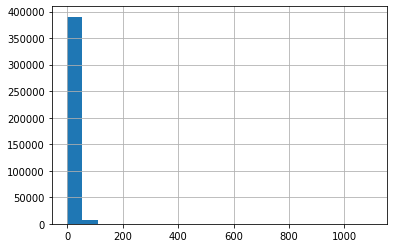

In [ ]:
gdf.fare_amount.hist(bins=20)

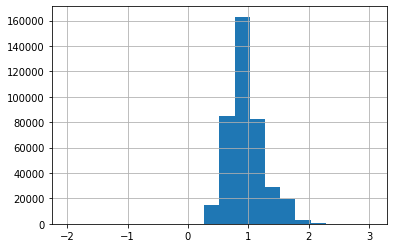

In [ ]:
np.log10(gdf.fare_amount).hist(bins=20)

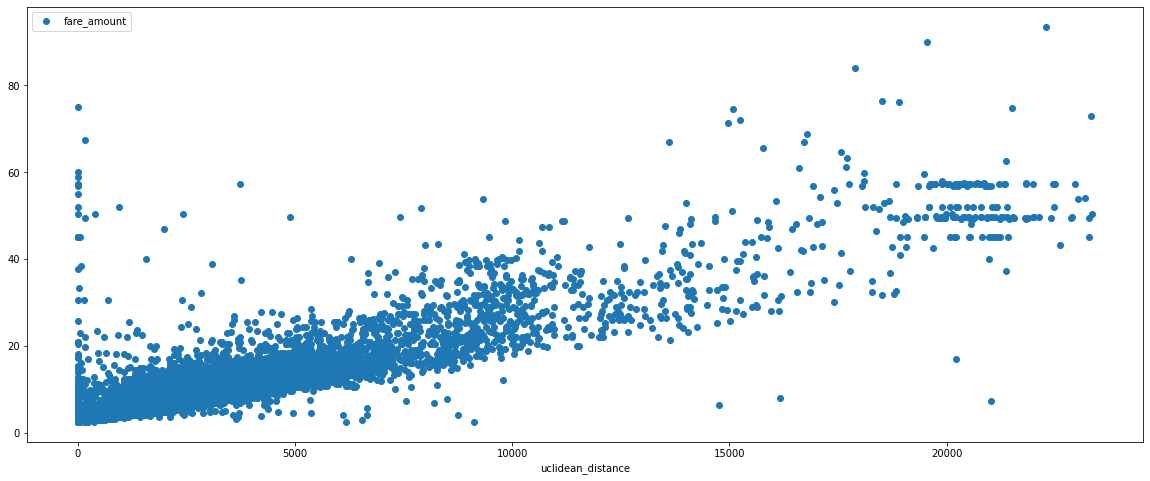

In [ ]:
gdf.plot(x='uclidean_distance',y='fare_amount',style='o')

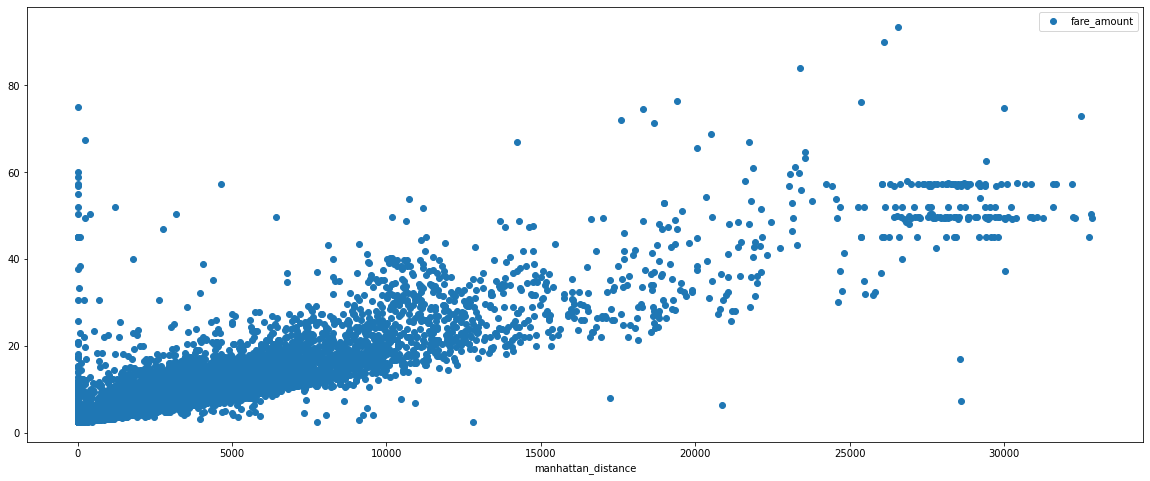

In [ ]:
gdf.plot(x='manhattan_distance',y='fare_amount',style='o')

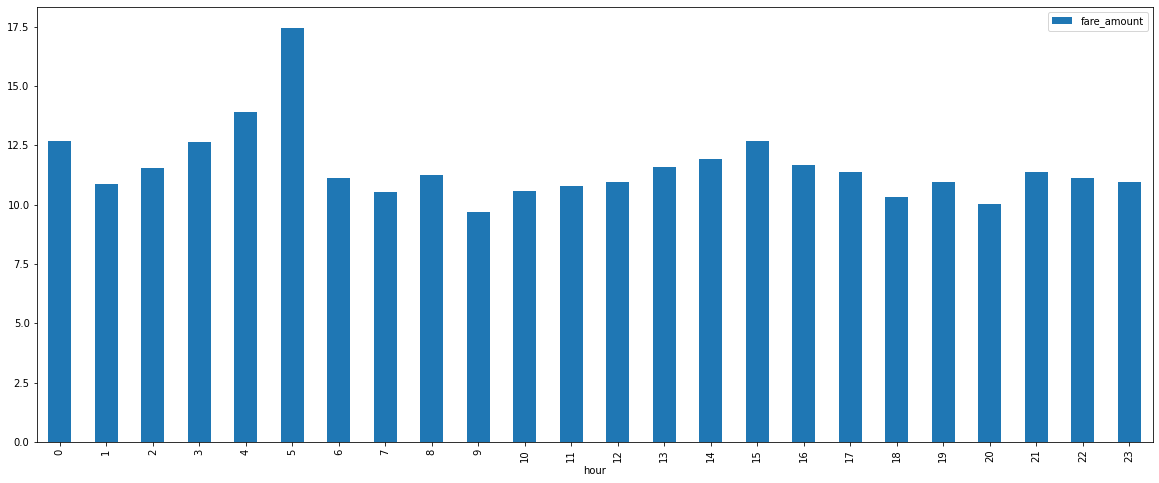

In [ ]:
gdf.groupby('hour').mean().plot.bar(y='fare_amount',style='bar')

In [ ]:
import geopandas as gpd
BBox = ((gdf.pickup_latitude.min(),gdf.pickup_longitude.min(),      
         gdf.pickup_latitude.max(), gdf.pickup_longitude.max()))
BBox

(40.563488, -74.1967, 41.36614, -73.13739)

In [ ]:
output.agg({'pickup_latitude':'min'}).show()
output.agg({'dropoff_latitude':'min'}).show()
output.agg({'pickup_latitude':'max'}).show()
output.agg({'dropoff_latitude':'max'}).show()
output.agg({'pickup_longitude':'min'}).show()
output.agg({'dropoff_longitude':'min'}).show()
output.agg({'pickup_longitude':'max'}).show()
output.agg({'dropoff_longitude':'max'}).show()

+--------------------+
|min(pickup_latitude)|
+--------------------+
|           37.285007|
+--------------------+

+---------------------+
|min(dropoff_latitude)|
+---------------------+
|            37.127605|
+---------------------+

+--------------------+
|max(pickup_latitude)|
+--------------------+
|                42.0|
+--------------------+

+---------------------+
|max(dropoff_latitude)|
+---------------------+
|             41.99665|
+---------------------+

+---------------------+
|min(pickup_longitude)|
+---------------------+
|                -75.0|
+---------------------+

+----------------------+
|min(dropoff_longitude)|
+----------------------+
|             -74.99701|
+----------------------+

+---------------------+
|max(pickup_longitude)|
+---------------------+
|                -73.0|
+---------------------+

+----------------------+
|max(dropoff_longitude)|
+----------------------+
|                 -73.0|
+----------------------+



In [ ]:
def get_route(pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude):

  r = requests.get(f"http://router.project-osrm.org/route/v1/car/{pickup_longitude},{pickup_latitude};{dropoff_longitude},{dropoff_latitude}?overview=false""")
  # then you load the response using the json libray
  # by default you get only one alternative so you access 0-th element of the `routes`
  routes = json.loads(r.content)
  distance,duration=0,0
  if routes.get("routes")!=None:
    distance=routes.get("routes")[0]["distance"]
    duration=routes.get("routes")[0]["duration"]
  print(distance,duration)
  return distance,duration

In [ ]:
import pyspark.sql.functions as F
import utm
from pyspark.sql.types import *

utm_udf_distance = F.udf(lambda pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude: get_route(pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude)[0] , FloatType())
utm_udf_duration = F.udf(lambda pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude: get_route(pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude)[1] , FloatType())

df2 = df2.withColumn('duration',utm_udf_duration( F.col('pickup_longitude'),F.col('pickup_latitude'),F.col('dropoff_longitude'),F.col('dropoff_latitude')))
df2 = df2.withColumn('distance',utm_udf_distance( F.col('pickup_longitude'),F.col('pickup_latitude'),F.col('dropoff_longitude'),F.col('dropoff_latitude')))


In [ ]:
df2=df2.drop('duration')
df2=df2.drop('distance')

In [ ]:
df2.tail(10)

[Row(key=190, fare_amount=6.9, pickup_datetime=datetime.datetime(2009, 2, 11, 15, 59), pickup_longitude=-73.994194, pickup_latitude=40.75114, dropoff_longitude=-73.97478, dropoff_latitude=40.75542, passenger_count=5, pickup_lon_utm=584907.8125, pickup_lat_utm=4511618.5, dropoff_lon_utm=586541.1875, dropoff_lat_utm=4512112.5, manhattan_distance=2127.375, uclidean_distance=1706.4436382796239, duration=227.8000030517578, distance=None),
 Row(key=191, fare_amount=19.7, pickup_datetime=datetime.datetime(2012, 1, 4, 18, 30), pickup_longitude=-74.0104, pickup_latitude=40.71137, dropoff_longitude=-73.943275, dropoff_latitude=40.77732, passenger_count=1, pickup_lon_utm=583589.5, pickup_lat_utm=4507188.0, dropoff_lon_utm=589171.375, dropoff_lat_utm=4514575.0, manhattan_distance=12968.875, uclidean_distance=9258.784883321623, duration=842.7000122070312, distance=12838.2998046875),
 Row(key=192, fare_amount=9.3, pickup_datetime=datetime.datetime(2009, 2, 14, 19, 53), pickup_longitude=-73.981026, p

In [ ]:
y_train=(y_train>10).astype(int)
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_train=(y_train>10).astype(int)
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C':[0.25,0.5,0.75,1.0],'kernel':['liner']},
              {'C':[0.25,0.5,0.75,1.0],'kernel':['rbf'],'gamma':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}]#list(np.arange(0.1,0.9,0.1))}]
grid_search = GridSearchCV(estimator = classifier, param_grid=parameters, scoring='accuracy',cv=10,n_jobs=-1)
grid_search.fit(X_train,y_train)
best_accuracy = grid_search.best_score_
best_paramters = grid_search.best_params_
print("Accuracy: {:.2f} %".format(best_accuracy*100))
print(f"Best Paramters: {best_paramters}")

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy: 88.60 %
Best Paramters: {'C': 1.0, 'gamma': 0.9, 'kernel': 'rbf'}


In [ ]:

from sklearn.linear_model import LinearRegression
regressor =  LinearRegression()
regressor.fit(X_train,y_train)
# y_train=sc_y.inverse_transform(y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=42,max_depth=8)
regressor.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
y_pred1 = regressor.predict(X_train)
r2_score(y_train, y_pred1)

0.842818535091255

In [ ]:
y_class=y_train>10
y_pred_class=y_pred>10
cm = confusion_matrix(y_class, y_pred_class)
print(cm)
accuracy_score(y_class, y_pred_class)

[[58258  4146]
 [ 7819 29777]]


0.88035

In [ ]:
y_class=y_train
y_pred_class=classifier.predict(X_train)
cm = confusion_matrix(y_class, y_pred_class)
print(cm)
accuracy_score(y_class, y_pred_class)

[[59257  3147]
 [ 8586 29010]]


0.88267

In [ ]:
y_class=(y_test>10).astype(int)
y_pred_class=classifier.predict(X_test)
cm = confusion_matrix(y_class, y_pred_class)
print(cm)
accuracy_score(y_class, y_pred_class)

[[59463  3163]
 [ 8811 28563]]


0.88026

In [ ]:
y_pred = regressor.predict(X_test)
r2_score(y_test, y_pred)

0.8068522508646816

In [ ]:
y_class=y_test>10
y_pred_class=y_pred>10
cm = confusion_matrix(y_class, y_pred_class)
print(cm)
accuracy_score(y_class, y_pred_class)

[[56847  5779]
 [ 7190 30184]]


0.87031

In [ ]:
!ls -la


total 511682
-rw------- 1 root root    738918 Jul 15 07:04 idc_test.csv
-rw------- 1 root root 503059860 Jul 15 07:22 idc_train.parquet
-rw------- 1 root root        62 Jul 15 05:59 kaggle.json
-rw------- 1 root root  20161578 Jul 15 16:10 samp.parquet


In [ ]:
df=pd.read_csv('idc_test.csv')
df['pickup_utm_lat'],df['pickup_utm_lon'],df['dropoff_utm_lat'],df['dropoff_utm_lon']=zip(*df.apply(lambda row: get_utm(row), axis=1))
df['distance']=df.apply(lambda row: get_distance(row),axis=1)
df['utm_dist']=(np.abs(df['pickup_utm_lat']-df['dropoff_utm_lat'])+np.abs(df['pickup_utm_lon']-df['dropoff_utm_lon']))/1000
df['pickup_datetime']=df['pickup_datetime'].apply(pd.to_datetime)
X=df[['utm_dist','passenger_count', 'distance', 'pickup_utm_lat', 'pickup_utm_lon','dropoff_utm_lat', 'dropoff_utm_lon']].values
# X = poly_reg.fit_transform(X)
X= sc_X.transform(X)
df['fare_amount'] = regressor.predict(X)
df['high_fare']=(df['fare_amount']>10).astype(int)
df[['key','high_fare']].to_csv('submission.csv',index=False)


In [ ]:
!kaggle competitions submit -c idc-big-data-platforms-2021-ml-competition -f submission.csv -m "DecisionTreeRegressor"

100% 107k/107k [00:00<00:00, 301kB/s]
Successfully submitted to IDC Big Data Platforms 2021 ML Competition

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
lr_model =lr.fit(train_data)
test_results= lr_model.evaluate(test_data)
preds_and_labels = test_results.predictions.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(f"Logistic Regression AUC: {test_results.areaUnderROC}")
cm =pd.DataFrame(metrics.confusionMatrix().toArray())
cm.index.rename('label',inplace=True)
cm.columns.rename('prediction',inplace=True)
print(cm)

19722 16500 0.049551269810960474 0.04145603650141202
361790
398012


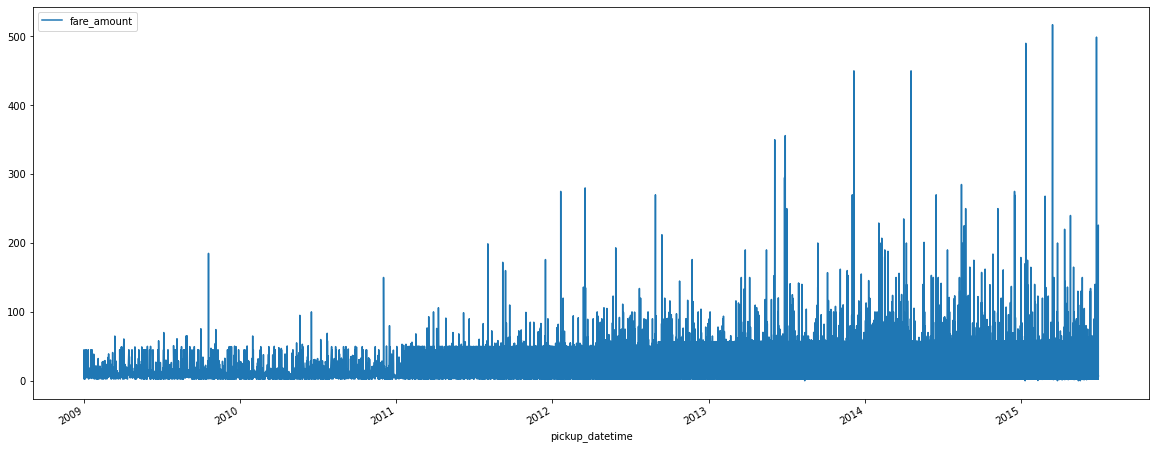

In [ ]:
count1=sum((gdf.fare_amount>=10)&~gdf.all0)
count0=sum((gdf.fare_amount<10)&~gdf.all0)
print(count0,count1,count0/len(gdf),count1/len(gdf))
gdf['all0']=(gdf['pickup_longitude']==0)&(gdf['pickup_latitude']==0)&(gdf['dropoff_longitude']==0)&(gdf['dropoff_latitude']==0)
print(sum(gdf['all0']))
print(len(gdf))
ax=gdf[~gdf['all0']].plot(x='pickup_datetime',y='fare_amount')
gdf['label']=(gdf['fare_amount']>10).astype('Int32')

In [ ]:
gdf

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,all0,label
0,130,6.9,2010-05-20 08:53:34,0.0,0.0,0.0,0.0,1,True,0
1,157,55.0,2014-03-04 11:53:00,0.0,0.0,0.0,0.0,2,True,1
2,186,9.3,2009-12-11 09:37:00,0.0,0.0,0.0,0.0,1,True,0
3,285,25.7,2012-07-01 23:44:24,0.0,0.0,0.0,0.0,2,True,1
4,392,41.0,2014-01-30 17:17:46,0.0,0.0,0.0,0.0,1,True,1
...,...,...,...,...,...,...,...,...,...,...
398007,19989914,7.7,2011-07-21 10:20:00,0.0,0.0,0.0,0.0,1,True,0
398008,19989916,13.5,2013-11-20 19:30:00,0.0,0.0,0.0,0.0,5,True,1
398009,19989922,6.5,2012-02-09 10:15:00,0.0,0.0,0.0,0.0,1,True,0
398010,19989945,11.5,2013-06-26 21:03:50,0.0,0.0,0.0,0.0,1,True,1
